## MSDS 430 Final Project
### by Kerry Kurcz
### December 8, 2019

The following notebook analyzes the behavior of U.S. Wildfires between 1992 and 2015.

1. The data is a sqlite file so there's some cleaning up there.
2. Then there is some exploratory analysis using pandas, numpy, seaborn, and matplotlib.
3. I will also attempt to regionalize the fires and then predict whether one region can predict fires in another region the following year.
4. Finally, the conclusions. Where are fires most prevalent? Can fires in one year in one region predict those in another region the next year? Is there some pattern country-wide?

## U.S. Wildfires
Source: https://www.kaggle.com/rtatman/188-million-us-wildfires/download#FPA_FOD_20170508.sqlite

Source info: https://www.kaggle.com/rtatman/188-million-us-wildfires/

Dates: 1992 - 2015

Region Source: https://www.worldatlas.com/articles/the-regions-of-the-united-states.html

In [1]:
import pandas
import numpy as np
import matplotlib.pyplot as plt
import sqlite3
import seaborn as sns
import pandas_profiling
import stats
conn = sqlite3.connect("../data/FPA_FOD_20170508.sqlite")
cur = conn.cursor()

plt.figure.max_open_warning = False

## Getting to understand the data
While Kaggle's documentation goes into detail about what's inside the SQLite file, I like to see for myself what tables are inside the instance I have in my memory, just to confirm they match. They do.

In [2]:
cur.execute("SELECT name FROM sqlite_master WHERE type='table';")
output = cur.fetchall()
tables = [table[0] for table in output]
tables.sort() # sorting alphabetically for readability
print(tables)

['ElementaryGeometries', 'Fires', 'KNN', 'NWCG_UnitIDActive_20170109', 'SpatialIndex', 'geometry_columns', 'geometry_columns_auth', 'geometry_columns_field_infos', 'geometry_columns_statistics', 'geometry_columns_time', 'idx_Fires_Shape', 'idx_Fires_Shape_node', 'idx_Fires_Shape_parent', 'idx_Fires_Shape_rowid', 'spatial_ref_sys', 'spatial_ref_sys_aux', 'spatialite_history', 'sql_statements_log', 'sqlite_sequence', 'views_geometry_columns', 'views_geometry_columns_auth', 'views_geometry_columns_field_infos', 'views_geometry_columns_statistics', 'virts_geometry_columns', 'virts_geometry_columns_auth', 'virts_geometry_columns_field_infos', 'virts_geometry_columns_statistics']


This project will focus only on the Fires table. 

## Getting column information from sqlite file itself, to later compare to pandas datafrae

In [3]:
query = cur.execute("SELECT * FROM fires;")
# this will point cur.description to the table fires

names = [description[0] for description in cur.description]
num_cols_fires = len(names)
# this I will not sort because the order should coordinate with data

print(names, "\n\n--> column count sqlite file : ", num_cols_fires)

['OBJECTID', 'FOD_ID', 'FPA_ID', 'SOURCE_SYSTEM_TYPE', 'SOURCE_SYSTEM', 'NWCG_REPORTING_AGENCY', 'NWCG_REPORTING_UNIT_ID', 'NWCG_REPORTING_UNIT_NAME', 'SOURCE_REPORTING_UNIT', 'SOURCE_REPORTING_UNIT_NAME', 'LOCAL_FIRE_REPORT_ID', 'LOCAL_INCIDENT_ID', 'FIRE_CODE', 'FIRE_NAME', 'ICS_209_INCIDENT_NUMBER', 'ICS_209_NAME', 'MTBS_ID', 'MTBS_FIRE_NAME', 'COMPLEX_NAME', 'FIRE_YEAR', 'DISCOVERY_DATE', 'DISCOVERY_DOY', 'DISCOVERY_TIME', 'STAT_CAUSE_CODE', 'STAT_CAUSE_DESCR', 'CONT_DATE', 'CONT_DOY', 'CONT_TIME', 'FIRE_SIZE', 'FIRE_SIZE_CLASS', 'LATITUDE', 'LONGITUDE', 'OWNER_CODE', 'OWNER_DESCR', 'STATE', 'COUNTY', 'FIPS_CODE', 'FIPS_NAME', 'Shape'] 

--> column count sqlite file :  39


## SQLite Rowcount
Before converting into pandas Dataframe, want to know the number of rows in SQLite file to assert conversion was successful.

In [4]:
cur.execute("SELECT COUNT(*) FROM fires;")
num_rows_fires = cur.fetchone()[0]
print("row count sqlite file : ", num_rows_fires)
# later we will confirm this is the same as in the dataframe

row count sqlite file :  1880465


In [5]:
sqlite_dim = (num_rows_fires, num_cols_fires)
# storing sqlite dimension information for convenience

## Creating the dataframe from SQLite file
According to Kaggle's documentation, FOD_ID is the global unique identifier. This will become the pandas index column.

In [6]:
# the step which stores fires table in pandas dataframe, df (takes a few minutes due to large file size)
df = pandas.read_sql("SELECT * FROM fires;", conn, index_col="FOD_ID") 

In [7]:
# verifying the length of the dataframe loaded is the same as that in the actual table, sqllite file
len(df) == num_rows_fires

True

Number of rows in both elements the same. I will now proceed further.

# First 5 elements

In [8]:
df.head(5)
# first 5 elements

,OBJECTID,FPA_ID,SOURCE_SYSTEM_TYPE,SOURCE_SYSTEM,NWCG_REPORTING_AGENCY,NWCG_REPORTING_UNIT_ID,NWCG_REPORTING_UNIT_NAME,SOURCE_REPORTING_UNIT,SOURCE_REPORTING_UNIT_NAME,LOCAL_FIRE_REPORT_ID,...,FIRE_SIZE_CLASS,LATITUDE,LONGITUDE,OWNER_CODE,OWNER_DESCR,STATE,COUNTY,FIPS_CODE,FIPS_NAME,Shape
FOD_ID,,,,,,,,,,,,,,,,,,,,,
1,1,FS-1418826,FED,FS-FIRESTAT,FS,USCAPNF,Plumas National Forest,0511,Plumas National Forest,1,...,A,40.036944,-121.005833,5.0,USFS,CA,63,063,Plumas,b'\x00\x01\xad\x10\x00\x00\xe8d\xc2\x92_@^\xc0...
2,2,FS-1418827,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,0503,Eldorado National Forest,13,...,A,38.933056,-120.404444,5.0,USFS,CA,61,061,Placer,b'\x00\x01\xad\x10\x00\x00T\xb6\xeej\xe2\x19^\...
3,3,FS-1418835,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,0503,Eldorado National Forest,27,...,A,38.984167,-120.735556,13.0,STATE OR PRIVATE,CA,17,017,El Dorado,b'\x00\x01\xad\x10\x00\x00\xd0\xa5\xa0W\x13/^\...
4,4,FS-1418845,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,0503,Eldorado National Forest,43,...,A,38.559167,-119.913333,5.0,USFS,CA,3,003,Alpine,b'\x00\x01\xad\x10\x00\x00\x94\xac\xa3\rt\xfa]...
5,5,FS-1418847,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,0503,Eldorado National Forest,44,...,A,38.559167,-119.933056,5.0,USFS,CA,3,003,Alpine,b'\x00\x01\xad\x10\x00\x00@\xe3\xaa.\xb7\xfb]\...


# Last 5 elements

In [9]:
df.tail(5)

# last 5 elements

,OBJECTID,FPA_ID,SOURCE_SYSTEM_TYPE,SOURCE_SYSTEM,NWCG_REPORTING_AGENCY,NWCG_REPORTING_UNIT_ID,NWCG_REPORTING_UNIT_NAME,SOURCE_REPORTING_UNIT,SOURCE_REPORTING_UNIT_NAME,LOCAL_FIRE_REPORT_ID,...,FIRE_SIZE_CLASS,LATITUDE,LONGITUDE,OWNER_CODE,OWNER_DESCR,STATE,COUNTY,FIPS_CODE,FIPS_NAME,Shape
FOD_ID,,,,,,,,,,,,,,,,,,,,,
300348363,1880461,2015CAIRS29019636,NONFED,ST-CACDF,ST/C&L,USCASHU,Shasta-Trinity Unit,CASHU,Shasta-Trinity Unit,591814,...,A,40.481637,-122.389375,13.0,STATE OR PRIVATE,CA,None,None,None,b'\x00\x01\xad\x10\x00\x00P\xb8\x1e\x85\xeb\x9...
300348373,1880462,2015CAIRS29217935,NONFED,ST-CACDF,ST/C&L,USCATCU,Tuolumne-Calaveras Unit,CATCU,Tuolumne-Calaveras Unit,569419,...,A,37.617619,-120.938570,12.0,MUNICIPAL/LOCAL,CA,None,None,None,b'\x00\x01\xad\x10\x00\x00\x00\x80\xbe\x88\x11...
300348375,1880463,2015CAIRS28364460,NONFED,ST-CACDF,ST/C&L,USCATCU,Tuolumne-Calaveras Unit,CATCU,Tuolumne-Calaveras Unit,574245,...,A,37.617619,-120.938570,12.0,MUNICIPAL/LOCAL,CA,None,None,None,b'\x00\x01\xad\x10\x00\x00\x00\x80\xbe\x88\x11...
300348377,1880464,2015CAIRS29218079,NONFED,ST-CACDF,ST/C&L,USCATCU,Tuolumne-Calaveras Unit,CATCU,Tuolumne-Calaveras Unit,570462,...,B,37.672235,-120.898356,12.0,MUNICIPAL/LOCAL,CA,None,None,None,b'\x00\x01\xad\x10\x00\x00x\xba_\xaa~9^\xc0\xb...
300348399,1880465,2015CAIRS26733926,NONFED,ST-CACDF,ST/C&L,USCABDU,San Bernardino Unit,CABDU,CDF - San Bernardino Unit,535436,...,A,34.263217,-116.830950,13.0,STATE OR PRIVATE,CA,None,None,None,b'\x00\x01\xad\x10\x00\x00\x1c\xa7\xe8H.5]\xc0...


In [10]:
# Extracting CA info 

CA = df[df['STATE']=='CA'] 
CA.head()

,OBJECTID,FPA_ID,SOURCE_SYSTEM_TYPE,SOURCE_SYSTEM,NWCG_REPORTING_AGENCY,NWCG_REPORTING_UNIT_ID,NWCG_REPORTING_UNIT_NAME,SOURCE_REPORTING_UNIT,SOURCE_REPORTING_UNIT_NAME,LOCAL_FIRE_REPORT_ID,...,FIRE_SIZE_CLASS,LATITUDE,LONGITUDE,OWNER_CODE,OWNER_DESCR,STATE,COUNTY,FIPS_CODE,FIPS_NAME,Shape
FOD_ID,,,,,,,,,,,,,,,,,,,,,
1,1,FS-1418826,FED,FS-FIRESTAT,FS,USCAPNF,Plumas National Forest,0511,Plumas National Forest,1,...,A,40.036944,-121.005833,5.0,USFS,CA,63,063,Plumas,b'\x00\x01\xad\x10\x00\x00\xe8d\xc2\x92_@^\xc0...
2,2,FS-1418827,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,0503,Eldorado National Forest,13,...,A,38.933056,-120.404444,5.0,USFS,CA,61,061,Placer,b'\x00\x01\xad\x10\x00\x00T\xb6\xeej\xe2\x19^\...
3,3,FS-1418835,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,0503,Eldorado National Forest,27,...,A,38.984167,-120.735556,13.0,STATE OR PRIVATE,CA,17,017,El Dorado,b'\x00\x01\xad\x10\x00\x00\xd0\xa5\xa0W\x13/^\...
4,4,FS-1418845,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,0503,Eldorado National Forest,43,...,A,38.559167,-119.913333,5.0,USFS,CA,3,003,Alpine,b'\x00\x01\xad\x10\x00\x00\x94\xac\xa3\rt\xfa]...
5,5,FS-1418847,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,0503,Eldorado National Forest,44,...,A,38.559167,-119.933056,5.0,USFS,CA,3,003,Alpine,b'\x00\x01\xad\x10\x00\x00@\xe3\xaa.\xb7\xfb]\...


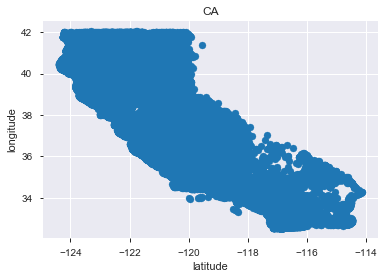

In [11]:
plt.scatter(CA["LONGITUDE"], CA["LATITUDE"])
plt.xlabel("latitude")
plt.ylabel("longitude")
plt.title("CA")
plt.savefig("CA.png")

# just thought it would be cool to plot California with Fire coordinates

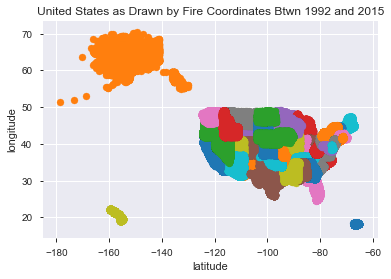

In [12]:
# going a step further to plot all the lat, long coordintes in the dataset

states = df["STATE"].unique()

for state in states:
    st = df[df["STATE"]==state]
    plt.scatter(st["LONGITUDE"], st["LATITUDE"])

plt.xlabel("latitude")
plt.ylabel("longitude")
plt.title("United States as Drawn by Fire Coordinates Btwn 1992 and 2015")
plt.savefig("united_states_kid_drawing.png".format(state))

In [ ]:
# plotting states individually

for state in states:
    st = df[df["STATE"]==state]
    plt.figure()
    plt.xlabel("latitude")
    plt.ylabel("longitude")
    plt.title(state)
    plt.scatter(st["LONGITUDE"], st["LATITUDE"])
    if state == "ND" or state == "NY" or state == "RI" or state == "NC":
        plt.savefig("{}.png".format(state))

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """


In [ ]:
# going a step further from head() by taking a look at the unique values of each attribute
unique_things = {}

for column in df.columns:
    unique_things[column] = df[column].unique()

In [ ]:
# printing unique_things in a somewhat human-friendly way
for key, val in unique_things.items():
    print("key: {}\nval:{}\n".format(key, val))

# I think the FIPS_NAME is kinda cool. I wonder if certain areas name their fires certain things?

In [ ]:
print("percent of the dataset missing name of fire : {} %".format(round(100*df["FIPS_NAME"].isna().sum()/len(df))))

only 36% of the dataset has the name of the fire missing, so I am not opposed to just removing those.

Of any of the above columns that has a proportion of missings greater than 0, I need to make some decisions. Anything higher than like, 80% I'm just going to drop without question. Some columns could be interesting though despite having such a high missing rate.

In [ ]:
proportions = 100 * (round(df.isnull().sum() / len(df), 4))

print(proportions)

DISCOVERY_TIME is about 40% missing but could be interesting to explore. So I'll use a legitimate time to represent a missing, to manipulate any program to work on the column but so the data scientist can understand that is what was missing.

It's an object, not a date. The above cell goes into seeing what some of the values look like, to replace it with something that hasn't been used, but still conforms to the pattern.

Looks like discovery time is entered without the colon using 4 characters in 24-hour format. For example, midnight would be 0000 and 2:15 pm would be 1415.

Replacing NaN's with 9999, since it should conform to the rest but it's not a real time so it wouldn't be mistaken for a real data point.

In [ ]:
times = list(df["DISCOVERY_TIME"].unique())
'9999' in times

In [ ]:
df["DISCOVERY_TIME"].fillna("9999", inplace=True)

COUNTY is 70% missing but can really be derived. I'm just curious to see if some Counties are good at reporting themselves. So I'm going to keep it. Replacing missing with something like "Not Specified".

Same with FIRE_NAME and FIPS_NAME.

In [ ]:
df["COUNTY"].fillna("Not Specified", inplace=True)
df["FIRE_NAME"].fillna("Not Specified", inplace=True)
df["FIPS_NAME"].fillna("Not Specified", inplace=True)

In [ ]:
# dropping columns which have high missing rates and/or just not interested in them

df.drop(columns = ["ICS_209_INCIDENT_NUMBER", "ICS_209_NAME", "LOCAL_INCIDENT_ID", "FIRE_CODE", "Shape",
                   "MTBS_ID", "MTBS_FIRE_NAME", "COMPLEX_NAME", "LOCAL_FIRE_REPORT_ID", "NWCG_REPORTING_UNIT_ID",
                  "OWNER_CODE", "CONT_TIME", "CONT_DOY", "CONT_DATE", "FIPS_CODE"], inplace = True)

In [ ]:
"ICS_209_INCIDENT_NUMBER" in df.columns # checking the drop worked correctly

In [ ]:
new_proportions = 100 * (round(df.isnull().sum() / len(df), 4))

print(new_proportions)

# Using matplotlib to visualize wildfire frequencies over time

## first I will add regionalized information

In [ ]:
# region information provided by WorldAtlas at
# https://www.worldatlas.com/articles/the-regions-of-the-united-states.html

west = ["WA", "OR", "ID", "MT", "CA", "NV", "UT", "AZ", "CO", "WY", "NM"]
midwest = ["ND", "SD", "MN", "WI", "IL", "IA", "NE", "KS", "MI", "OH", "IN"]
south = ["TX", "OK", "AR", "LA", "AL", "GA", "FL", "TN", "KY", "WV", "VA", "MD", "NC", "SC", "MS", "MO"]
northeast = ["ME", "NH", "VT", "NY", "DE", "PA", "RI", "CT", "MA", "NJ"]
other = ["AK", "HI", "PR", "DC"]

regions = {"west": west, "midwest": midwest, "south": south, "northeast": northeast, "other": other} # I ignore the others region

print(len(west)+len(midwest)+len(south)+len(northeast)+len(other)) # want this to be 52, for 50 states plug PR and DC

In [ ]:
df["REGION"] = -1

In [ ]:
import numpy as np

for state in west:
    df['REGION'] = np.where(df["STATE"]==state,   #Identifies the case to apply to
                            "west",               #This is the value that is inserted
                            df["REGION"])         #This is the column that is affected
        
for state in midwest:
    df['REGION'] = np.where(df["STATE"]==state,
                            "midwest",
                            df["REGION"])
    
for state in south:
    df['REGION'] = np.where(df["STATE"]==state,
                            "south",
                            df["REGION"])

for state in northeast:
    df['REGION'] = np.where(df["STATE"]==state,
                            "northeast",
                            df["REGION"])

for state in other:
    df["REGION"] = np.where(df["STATE"]==state,
                           "other",
                           df["REGION"])

In [ ]:
# if -1 is not in this list, all states now have a region
df["REGION"].unique()

## getting distributions of fires per year

In [ ]:
# This gives a frequency distribution of all the years

years = df["FIRE_YEAR"]
plt.hist(years, bins=len(df["FIRE_YEAR"].unique()))
plt.title("Fire Year Frequencies")
plt.xlabel("Year")
plt.ylabel("Frequency")
plt.savefig("fire_frequencies_by_year_total.png")

In [ ]:
# curious about discovery date, how or if it differs

plt.hist(df["DISCOVERY_DATE"], bins=len(df["FIRE_YEAR"].unique()))
plt.title("Discovery Date Frequencies")
plt.xlabel("Year")
plt.ylabel("Frequency")
plt.show()

Doesn't look like it really does

### Distributions of fires per year, by region

In [ ]:
for key, val in regions.items():
    plt.figure()
    sub_df = df[df["REGION"]==key]
    plt.hist(sub_df["FIRE_YEAR"], bins=len(df["FIRE_YEAR"].unique()))
    plt.title("Frequencies per Year for Region {}".format(key))
    plt.xlabel("Year")
    plt.ylabel("Frequency")
    plt.savefig("{}_distribution".format(key))

Where it is dry in the midwest, there's a pretty consistent high number of fires. Northeast and midwest regions have definitely increased over time. The south had a dip somewhere around 2005, then spiked back up.

In [ ]:
df.columns

In [ ]:
df.head()

In [ ]:
df.index = df["FPA_ID"]

In [ ]:
df.head()

In [ ]:
df.drop(columns = ["OBJECTID", "FPA_ID", "DISCOVERY_DATE"], inplace=True)

In [ ]:
df.dtypes

In [ ]:
# filtering for only numeric datatypes in prep for Pearson coefficiant

numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

numerics = df.select_dtypes(include=numerics)
numerics.columns

In [ ]:
numerics.head()

In [ ]:
# lat and long are not necessary for numerical analysis

numerics.drop(columns=["LATITUDE", "LONGITUDE"], inplace=True)

In [ ]:
# SOURCE_REPORTING_UNIT looks like it might be able to behave as numeric

try: 
    df["SOURCE_REPORTING_UNIT"].astype("int64")
except:
    print("no can do")

### okey dokey, nevermind to that. I do want region in there, however

In [ ]:
numerics = numerics.join(df["REGION"].str.get_dummies())

In [ ]:
numerics.dtypes

In [ ]:
numerics.head()

In [ ]:
# box plot of fire year by state
sns.boxplot(df[["STATE"]])

In [ ]:
CA_corr.savefig("CA_pearson_correlation_coeff.png")